# `xarrayvideo` for a custom set of cubes

Notebook setup

In [1]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

Load required libraries

In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray, gap_fill, plot_image, to_netcdf
import matplotlib.pyplot as plt

Load the data

In [3]:
import pickle

output_path= './out'
file= '../cubos_julio/cubo1_pickle'
with open(file, 'rb') as file:
    data = pickle.load(file)
    
jc_data= data.to_dataset(dim='band')
jc_data

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 108, y: 1280, x: 1280)
Coordinates:
  * time     (time) <U8 3kB '20151015' '20151115' ... '20240815' '20240915'
  * y        (y) float64 10kB 8.955e+06 8.955e+06 ... 8.942e+06 8.942e+06
  * x        (x) float64 10kB 2.218e+05 2.218e+05 ... 2.346e+05 2.346e+05
Data variables:
    1        (time, y, x) uint16 354MB 892 881 1023 1108 ... 990 1000 1016 1035
    2        (time, y, x) uint16 354MB 803 825 1045 1194 ... 1000 1017 1042 1054
    3        (time, y, x) uint16 354MB 689 705 954 993 ... 1158 1195 1234 1278
    4        (time, y, x) uint16 354MB 834 867 1193 1239 ... 1279 1361 1385 1483
    5        (time, y, x) uint16 354MB 1172 1271 2236 2342 ... 1545 1566 1666
    6        (time, y, x) uint16 354MB 1363 1470 2506 2639 ... 1680 1708 1850
    7        (time, y, x) uint16 354MB 1360 1307 2228 3781 ... 1704 1763 1843
    8        (time, y, x) uint16 354MB 1627 1734 2777 2894 ... 1892 1930 2122
    9        (time, y, x) uint16 354MB 1810 1834 2075 2103 ... 2560 2617 2906
    10       (time, y, x) uint16 354MB 1213 1228 1377 1398 ... 1747 1793 1988

Compress

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

all: 3375.00Mb -> ['26.77', '48.68', '74.36', '26.90']Mb (showing last 10)(5.24% of original size, 0.8377 bpppb) in 98.84s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [50], 'x265-params': 'qpmin=0:qpmax=0.1:psy-rd=0:psy-rdoq=0'}
 - Decompression time 8.03s


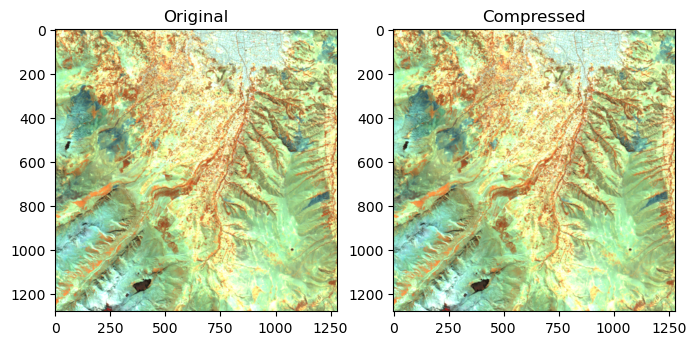

Saturation values per band [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10]):
 [[2.4100e+02 2.1053e+04]
 [1.5300e+02 1.8219e+04]
 [0.0000e+00 2.7405e+04]
 [0.0000e+00 1.6461e+04]
 [0.0000e+00 1.9447e+04]
 [0.0000e+00 2.0266e+04]
 [0.0000e+00 1.8689e+04]
 [0.0000e+00 1.6849e+04]
 [4.9000e+01 1.4278e+04]
 [2.5000e+01 1.4353e+04]
 [2.5000e+01 1.4353e+04]
 [2.5000e+01 1.4353e+04]]
Using only 5.65% of data for metrics computation. Adjust this by modifying global variable METRICS_MAX_N=100000000.0
 - SSIM_sat 0.997684
 - MSE_sat 712.869324
 - PSNR_sat 55.3962
 - Exp. SA 0.0146 
Metrics took 79.43s to run


In [9]:
lossy_params = {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [50],#,1,3,6,9], #14 default, 11 for higher quality and size
    'x265-params': 'qpmin=0:qpmax=0.1:psy-rd=0:psy-rdoq=0',
    }
image_lossy_params= {
    'codec': 'JP2OpenJPEG',
    'QUALITY': '5', #100 for lossless, less than that for lossy
    # 'REVERSIBLE': 'YES',  #YES for lossless
    'YCBCR420':'NO',
    'WRITE_METADATA': 'NO'
    }

conversion_rules= {
    # 'rgb': (['B4', 'B3', 'B2'], ('time', 'x', 'y'), 0, lossy_params, 12, [0,0.4]),
    
    'all': (list(jc_data.data_vars), ('time', 'x', 'y'), 0, lossy_params, 12), #Using video
    # 'all': (cesar_bands, ('time', 'x', 'y'), 9, lossy_params, 12), #Using video with PCA
    # 'all': (cesar_bands, ('time', 'x', 'y'), 0, image_lossy_params, 16), #Using image
    }

arr_dict= xarray2video(jc_data, 'custom', conversion_rules,
                       output_path=output_path, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset=True #Disable saving?
                       )  

In [10]:
new_path= str(Path(output_path) / 'custom')
!du -h {new_path} 

200M	out/custom


Read again the written file, and check that everything has persisted

In [14]:
jc_data_new= video2xarray(output_path, 'custom', x_name='x', y_name='y', transpose=False) 
jc_data_new

<xarray.Dataset> Size: 7GB
Dimensions:  (time: 108, y: 1280, x: 1280)
Coordinates:
  * time     (time) <U8 3kB '20151015' '20151115' ... '20240815' '20240915'
  * y        (y) float64 10kB 8.955e+06 8.955e+06 ... 8.942e+06 8.942e+06
  * x        (x) float64 10kB 2.218e+05 2.218e+05 ... 2.346e+05 2.346e+05
Data variables:
    1        (time, y, x) float32 708MB 891.5 962.7 ... 1.054e+03 1.059e+03
    2        (time, y, x) float32 708MB 805.9 867.7 ... 1.071e+03 1.062e+03
    3        (time, y, x) float32 708MB 716.1 809.8 ... 1.298e+03 1.292e+03
    4        (time, y, x) float32 708MB 840.1 828.1 ... 1.471e+03 1.467e+03
    5        (time, y, x) float32 708MB 1.201e+03 1.201e+03 ... 1.672e+03
    6        (time, y, x) float32 708MB 1.356e+03 1.351e+03 ... 1.856e+03
    7        (time, y, x) float32 708MB 1.392e+03 1.492e+03 ... 1.839e+03
    8        (time, y, x) float32 708MB 1.605e+03 1.629e+03 ... 2.123e+03
    9        (time, y, x) float32 708MB 1.835e+03 1.849e+03 ... 2.877e+03
    10       (time, y, x) float32 708MB 1.218e+03 1.218e+03 ... 1.981e+03

Visualize results

In [ ]:
#RGB
plot_image(jc_data/10000., [3,2,1], mask_name=None, stack_every=12, save_name='./out/RGB original_custom.jpg')
plot_image(jc_data_new/10000., [3,2,1], mask_name=None, stack_every=12, save_name='./out/RGB compressed_custom.jpg')